<a href="https://colab.research.google.com/github/matd-start/Gestor-Tareas/blob/main/ProyectoCapstone_FitInsights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Proyecto Capstone: FitInsights
## Soluciones de Futuro con IA y Datos (Nivel Avanzado)


In [ ]:
# bibliotecas
!pip install pandas numpy matplotlib seaborn --quiet
!pip install scikit-learn umap-learn --quiet
!pip install pyspark --quiet
!pip install pymongo dnspython --quiet
!pip install confluent-kafka --quiet
!pip install geopandas contextily folium --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 82.6 MB/s eta 0:00:00


In [ ]:
# Generación de datos sintéticos
import pandas as pd
import numpy as np
import datetime

# Configuración
num_registros = 500
num_atletas = 50
lat_base, lon_base = 4.60971, -74.08175 # Bogotá

# Listas de IDs de atletas
ids_atletas = [f"A{str(i).zfill(3)}" for i in range(1, num_atletas + 1)]

# Generar datos
data = {
    'atleta_id': np.random.choice(ids_atletas, num_registros),
    'fecha': [datetime.date(2023, 1, 1) + datetime.timedelta(days=int(d)) for d in np.random.randint(0, 600, num_registros)],
    'velocidad': np.random.normal(12, 2.5, num_registros), # km/h
    'resistencia': np.random.normal(60, 15, num_registros), # minutos
    'fc_media': np.random.normal(150, 10, num_registros), # bpm
    'latitud': np.random.normal(lat_base, 0.05, num_registros),
    'longitud': np.random.normal(lon_base, 0.05, num_registros)
}

df = pd.DataFrame(data)

# Introducir algunos nulos para limpieza [cite: 149]
for col in ['velocidad', 'resistencia', 'fc_media']:
    df.loc[df.sample(frac=0.05).index, col] = np.nan

# Introducir algunos outliers para recortar [cite: 150]
df.loc[df.sample(frac=0.02).index, 'velocidad'] = np.random.uniform(30, 50, int(num_registros*0.02))
df.loc[df.sample(frac=0.01).index, 'resistencia'] = np.random.uniform(180, 240, int(num_registros*0.01))

# Guardar el CSV
df.to_csv('datos_atletas.csv', index=False)

print(f"Archivo 'datos_atletas.csv' generado con {len(df)} registros.")
df.head()

Archivo 'datos_atletas.csv' generado con 500 registros.


,atleta_id,fecha,velocidad,resistencia,fc_media,latitud,longitud
0,A019,2023-08-30,8.615464,NaN,161.665495,4.610184,-74.017260
1,A037,2023-11-18,14.997380,65.981963,141.815482,4.577188,-74.072138
2,A026,2024-01-07,14.981059,NaN,139.300505,4.601576,-74.062595
3,A026,2023-04-25,11.723809,60.697860,145.036530,4.582355,-74.090469
4,A019,2023-10-29,12.480247,92.840654,136.287608,4.632615,-74.072335


In [ ]:
# Carga y Limpieza
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos
df = pd.read_csv('datos_atletas.csv')
df['fecha'] = pd.to_datetime(df['fecha']) # Convertir fecha

print("--- Información Original ---")
df.info()

# 1. Eliminar filas con nulos en columnas clave
columnas_clave = ['velocidad', 'resistencia', 'fc_media']
df_clean = df.dropna(subset=columnas_clave).copy()
print(f"\nRegistros antes de dropna: {len(df)}, después: {len(df_clean)}")

# 2. Recortar extremos (percentiles 1 y 99)
metricas = ['velocidad', 'resistencia', 'fc_media']
for col in metricas:
    p01 = df_clean[col].quantile(0.01)
    p99 = df_clean[col].quantile(0.99)
    df_clean[col] = np.clip(df_clean[col], p01, p99)
    print(f"Recortando '{col}' entre {p01:.2f} y {p99:.2f}")

print("\n--- Información Limpia ---")
df_clean.describe()

--- Información Original ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   atleta_id    500 non-null    object        
 1   fecha        500 non-null    datetime64[ns]
 2   velocidad    476 non-null    float64       
 3   resistencia  475 non-null    float64       
 4   fc_media     475 non-null    float64       
 5   latitud      500 non-null    float64       
 6   longitud     500 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 27.5+ KB

Registros antes de dropna: 500, después: 430
Recortando 'velocidad' entre 6.21 y 38.36
Recortando 'resistencia' entre 19.91 y 164.13
Recortando 'fc_media' entre 128.85 y 177.20

--- Información Limpia ---


,fecha,velocidad,resistencia,fc_media,latitud,longitud
count,430,430.000000,430.000000,430.000000,430.000000,430.000000
mean,2023-11-09 01:23:43.255814144,12.467717,61.643783,150.040500,4.608863,-74.083592
min,2023-01-01 00:00:00,6.207640,19.909477,128.853148,4.411943,-74.233417
25%,2023-06-16 06:00:00,10.347286,51.527216,143.026595,4.574966,-74.117622
50%,2023-11-16 12:00:00,12.109370,61.062751,149.596653,4.610673,-74.084673
75%,2024-04-15 00:00:00,13.774077,70.508697,156.718865,4.645058,-74.052549
max,2024-08-19 00:00:00,38.357224,164.126128,177.198328,4.755801,-73.919556
std,NaN,4.276132,18.507372,10.039573,0.052299,0.048992


--- Estadísticas Descriptivas (Datos Limpios) ---
        velocidad  resistencia    fc_media
count  430.000000   430.000000  430.000000
mean    12.467717    61.643783  150.040500
std      4.276132    18.507372   10.039573
min      6.207640    19.909477  128.853148
25%     10.347286    51.527216  143.026595
50%     12.109370    61.062751  149.596653
75%     13.774077    70.508697  156.718865
max     38.357224   164.126128  177.198328


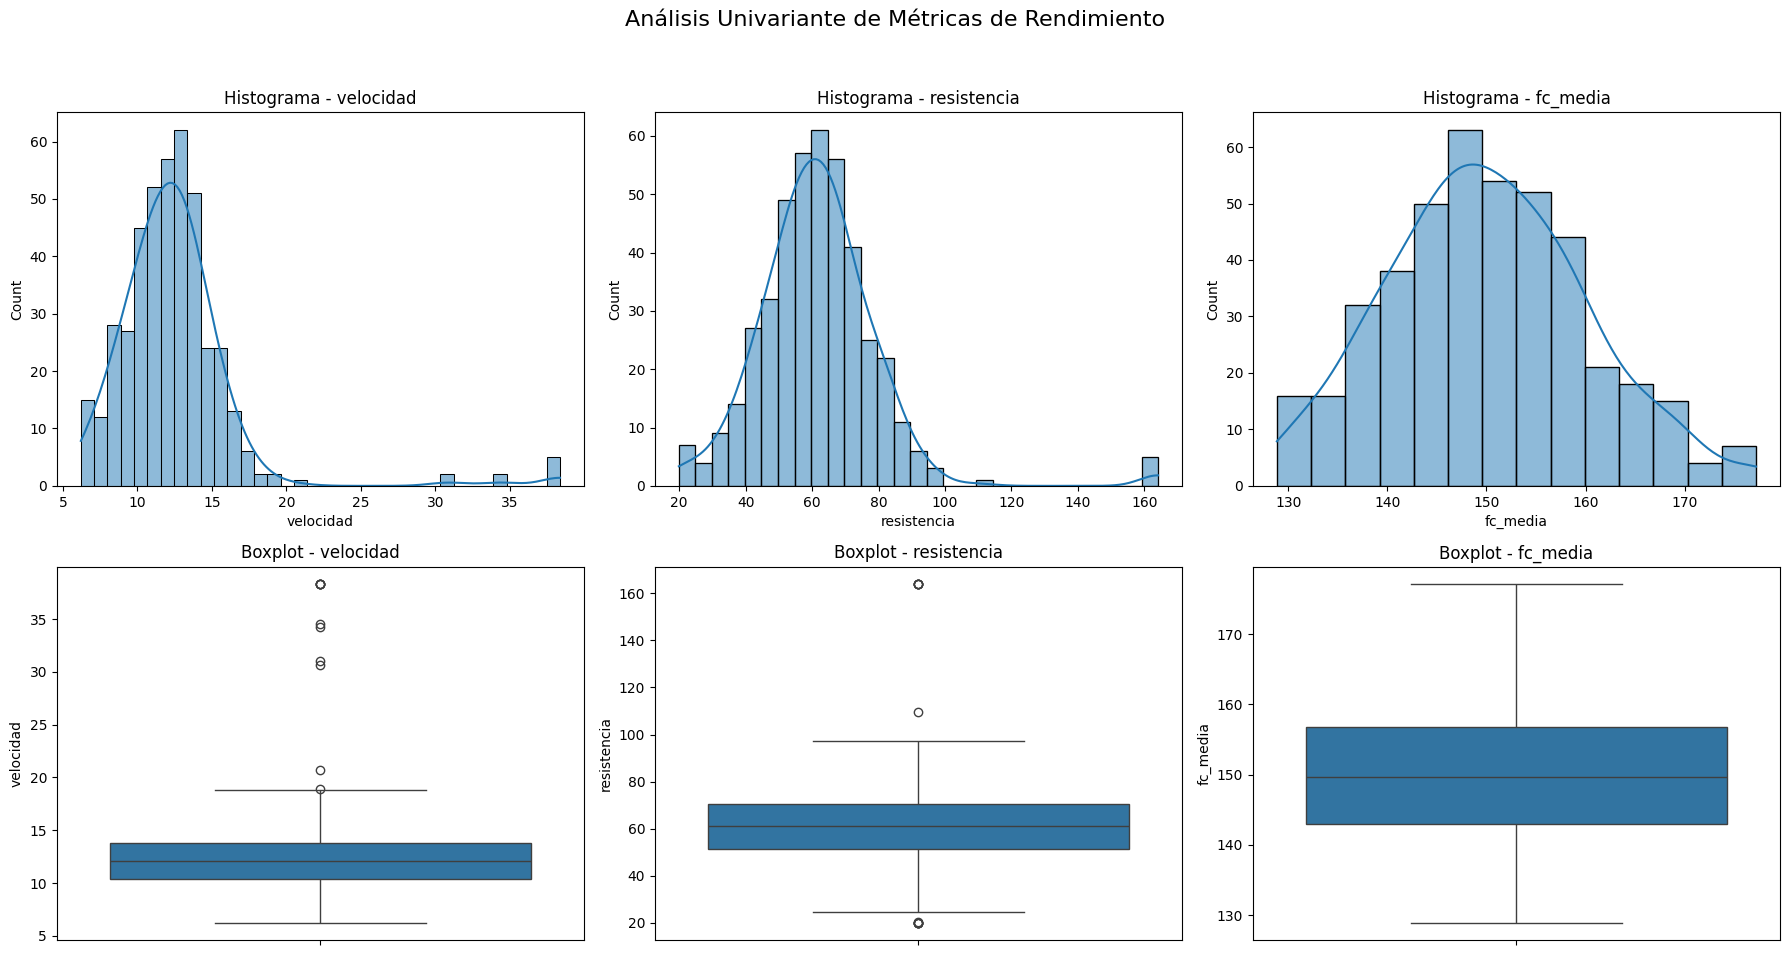

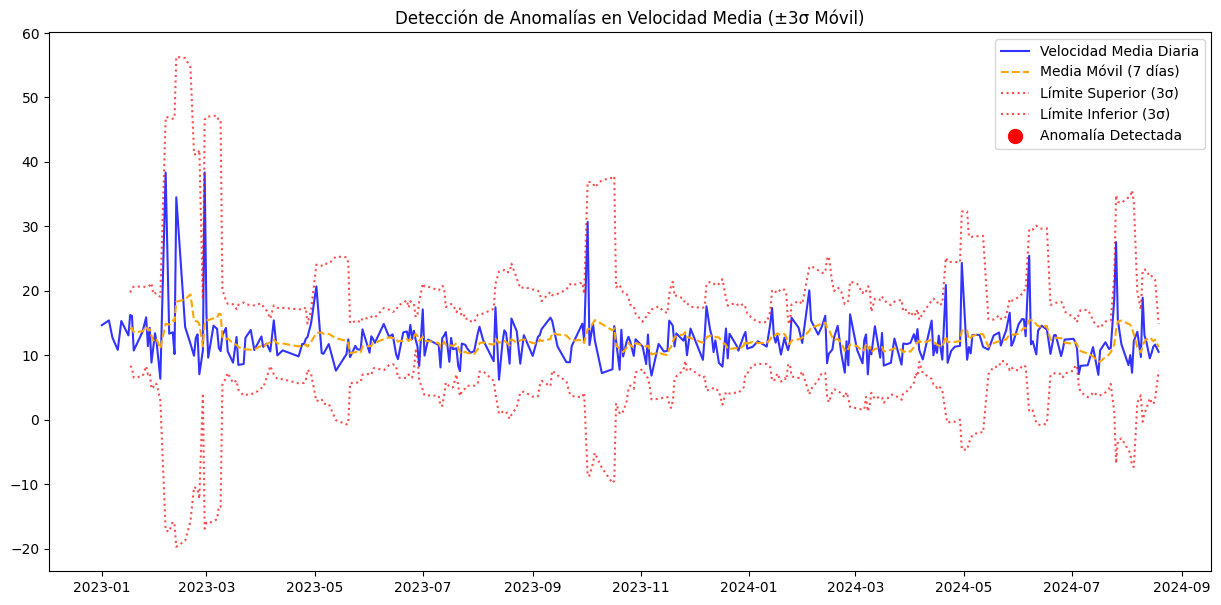

--- Fechas Atípicas Detectadas (0) ---
Empty DataFrame
Columns: [velocidad, media_movil, std_movil, limite_superior, limite_inferior, anomalia]
Index: []


In [ ]:
# EDA - Estadísticas y Visualizaciones Univariantes
print("--- Estadísticas Descriptivas (Datos Limpios) ---")
print(df_clean[metricas].describe())

# Histogramas y Boxplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Análisis Univariante de Métricas de Rendimiento', fontsize=16)

for i, col in enumerate(metricas):
    sns.histplot(df_clean[col], kde=True, ax=axes[0, i])
    axes[0, i].set_title(f'Histograma - {col}')
    sns.boxplot(y=df_clean[col], ax=axes[1, i])
    axes[1, i].set_title(f'Boxplot - {col}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Celda 5: EDA - Detección de Anomalías Temporales
# Agregamos los datos por día para la serie temporal
df_ts = df_clean.groupby('fecha')[['velocidad']].mean().sort_index()

# 1. Cálculo de ritmo móvil (7 días)
window_size = 7
df_ts['media_movil'] = df_ts['velocidad'].rolling(window=window_size).mean()
df_ts['std_movil'] = df_ts['velocidad'].rolling(window=window_size).std()

# 2. Límites de ±3 desviaciones estándar
df_ts['limite_superior'] = df_ts['media_movil'] + (3 * df_ts['std_movil'])
df_ts['limite_inferior'] = df_ts['media_movil'] - (3 * df_ts['std_movil'])

# 3. Identificar anomalías
df_ts['anomalia'] = (df_ts['velocidad'] > df_ts['limite_superior']) | \
                    (df_ts['velocidad'] < df_ts['limite_inferior'])

# 4. Gráfica
plt.figure(figsize=(15, 7))
plt.plot(df_ts.index, df_ts['velocidad'], label='Velocidad Media Diaria', color='blue', alpha=0.8)
plt.plot(df_ts.index, df_ts['media_movil'], label=f'Media Móvil ({window_size} días)', color='orange', linestyle='--')
plt.plot(df_ts.index, df_ts['limite_superior'], label='Límite Superior (3σ)', color='red', linestyle=':', alpha=0.7)
plt.plot(df_ts.index, df_ts['limite_inferior'], label='Límite Inferior (3σ)', color='red', linestyle=':', alpha=0.7)

# Resaltar anomalías
anomalies = df_ts[df_ts['anomalia']]
plt.scatter(anomalies.index, anomalies['velocidad'], color='red', label='Anomalía Detectada', zorder=5, s=100)

plt.title('Detección de Anomalías en Velocidad Media (±3σ Móvil)')
plt.legend()
plt.show()

print(f"--- Fechas Atípicas Detectadas ({len(anomalies)}) ---")
print(anomalies)

In [ ]:
import pymongo
from pymongo.server_api import ServerApi

ATLAS_URI = "mongodb+srv://(tu usuario).mongodb.net/?retryWrites=true&w=majority"

try:
    # Conectar al clúster
    client = pymongo.MongoClient(ATLAS_URI, server_api=ServerApi('1'))
    client.admin.command('ping')
    print("Conexión a MongoDB Atlas exitosa.")

    db = client['fitinsights']
    collection = db['atletas']

    # Insertar el DataFrame limpio
    collection.delete_many({})
    print(f"Colección 'atletas' limpiada.")

    df_mongo = df_clean.copy()
    df_mongo['fecha'] = df_mongo['fecha'].apply(lambda x: x.to_pydatetime())

    data_dict = df_mongo.to_dict('records')
    result = collection.insert_many(data_dict)
    print(f"Insertados {len(result.inserted_ids)} documentos.")

    # 3. Crear índice sobre atleta_id
    collection.create_index("atleta_id")
    print("Índice creado sobre 'atleta_id'.")

    # 4. Ejemplo de consulta simple
    print("\n--- Ejemplo de Consulta (velocidad > 15) ---")
    consulta = collection.find_one({'velocidad': {'$gt': 15}})
    print(consulta)

except Exception as e:
    print(f"Error conectando o insertando en MongoDB: {e}")


Conexión a MongoDB Atlas exitosa.
Colección 'atletas' limpiada.
Insertados 430 documentos.
Índice creado sobre 'atleta_id'.

--- Ejemplo de Consulta (velocidad > 15) ---
{'_id': ObjectId('690116ba6eec7f13ce3fa8cb'), 'atleta_id': 'A018', 'fecha': datetime.datetime(2024, 7, 26, 0, 0), 'velocidad': 16.745287978753634, 'resistencia': 69.33408174470226, 'fc_media': 152.7529717252038, 'latitud': 4.738337203314226, 'longitud': -74.17806338714617}


In [ ]:
# Simulación de Streaming con Kafka
from confluent_kafka import Producer, Consumer, KafkaException
import json, time, threading

# Configuración del productor y consumidor (simulado local)
conf = {
    'bootstrap.servers': 'localhost:9092',  # Kafka local simulado
    'group.id': 'fitinsights_group',
    'auto.offset.reset': 'earliest'
}

# Simular un productor en hilo separado
def producir_eventos():
    print("Iniciando productor simulado...")
    for i in range(50):
        evento = {
            "atleta_id": np.random.choice(df_clean['atleta_id']),
            "timestamp": pd.Timestamp.now().isoformat(),
            "velocidad": round(np.random.normal(12, 2.5), 2),
            "resistencia": round(np.random.normal(60, 15), 2)
        }
        print(f"→ Evento enviado: {evento}")
        time.sleep(0.2)
    print("Simulación de envío completada.")

# sí simular la llegada de mensajes:
threading.Thread(target=producir_eventos).start()


Iniciando productor simulado...
→ Evento enviado: {'atleta_id': 'A007', 'timestamp': '2025-10-28T19:15:19.699998', 'velocidad': 10.66, 'resistencia': 72.72}


In [ ]:
# Transformación con Spark SQL
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# sesión de Spark
spark = SparkSession.builder \
    .appName("FitInsights-Spark") \
    .getOrCreate()

print("Sesión Spark iniciada correctamente.")


→ Evento enviado: {'atleta_id': 'A042', 'timestamp': '2025-10-28T19:15:19.960952', 'velocidad': 12.39, 'resistencia': 42.5}
→ Evento enviado: {'atleta_id': 'A049', 'timestamp': '2025-10-28T19:15:20.175818', 'velocidad': 11.29, 'resistencia': 81.95}
→ Evento enviado: {'atleta_id': 'A019', 'timestamp': '2025-10-28T19:15:20.376845', 'velocidad': 10.24, 'resistencia': 86.07}
→ Evento enviado: {'atleta_id': 'A017', 'timestamp': '2025-10-28T19:15:20.579270', 'velocidad': 13.33, 'resistencia': 40.41}
→ Evento enviado: {'atleta_id': 'A007', 'timestamp': '2025-10-28T19:15:20.785727', 'velocidad': 14.16, 'resistencia': 66.26}
→ Evento enviado: {'atleta_id': 'A027', 'timestamp': '2025-10-28T19:15:20.986674', 'velocidad': 11.5, 'resistencia': 64.3}
→ Evento enviado: {'atleta_id': 'A039', 'timestamp': '2025-10-28T19:15:21.190098', 'velocidad': 8.5, 'resistencia': 53.81}
→ Evento enviado: {'atleta_id': 'A022', 'timestamp': '2025-10-28T19:15:21.393367', 'velocidad': 9.32, 'resistencia': 61.59}
→ Even

In [ ]:
# Cargar el CSV limpio
df_spark = spark.read.csv("datos_atletas.csv", header=True, inferSchema=True)

# Vista previa
df_spark.show(5)
df_spark.printSchema()


+---------+----------+------------------+------------------+------------------+-----------------+------------------+
|atleta_id|     fecha|         velocidad|       resistencia|          fc_media|          latitud|          longitud|
+---------+----------+------------------+------------------+------------------+-----------------+------------------+
|     A019|2023-08-30| 8.615464270541327|              NULL| 161.6654950557084|4.610183872635287|-74.01726007388949|
|     A037|2023-11-18| 14.99737971408815| 65.98196299229701|141.81548201379974|4.577187874619568|-74.07213846609625|
|     A026|2024-01-07|14.981059346136368|              NULL|139.30050544673338|4.601576202386484|-74.06259532232713|
|     A026|2023-04-25|11.723808814031868|60.697859689457246|145.03653047902196|4.582355184207539|-74.09046894053886|
|     A019|2023-10-29|12.480247215510241| 92.84065373578551|136.28760750313157|4.632615055867105|-74.07233516358119|
+---------+----------+------------------+------------------+----

In [ ]:
# Agrupar por atleta y calcular métricas promedio
df_agg = df_spark.groupBy("atleta_id").agg(
    F.count("*").alias("num_registros"),
    F.mean("velocidad").alias("velocidad_prom"),
    F.mean("resistencia").alias("resistencia_prom"),
    F.mean("fc_media").alias("fc_media_prom")
)

# Ordenar para visualización ordenada
df_agg = df_agg.orderBy("atleta_id")
df_agg.show(10)


+---------+-------------+------------------+------------------+------------------+
|atleta_id|num_registros|    velocidad_prom|  resistencia_prom|     fc_media_prom|
+---------+-------------+------------------+------------------+------------------+
|     A001|            9|12.754047440455647| 61.62041324888699|150.72922205288714|
|     A002|           13|10.313979862812646| 61.41784332978572| 157.4366201430585|
|     A003|           10|11.760568829732378| 60.46565062745108|150.99549753379344|
|     A004|           10| 12.48120638712487| 65.42552881576987|147.51852962917155|
|     A005|            9|12.714383662027055| 63.12333614330363|153.26210989119554|
|     A006|            8| 11.63753917263557|60.853545350828654| 146.6942677199453|
|     A007|            7|11.327333004755042| 77.77546322769419|148.86282420737004|
|     A008|            9|12.911205361412309|61.571991441921355|155.19246716052055|
|     A009|            9|11.267494045222392| 52.85963061855612|152.46765868049226|
|   

In [ ]:
# Exportar resultados
df_agg.toPandas().to_csv("atletas_agg.csv", index=False)
print("Archivo 'atletas_agg.csv' generado correctamente.")


Archivo 'atletas_agg.csv' generado correctamente.


# resumen de lo hecho con spark
ETL (Extraer, Transformar, Cargar). Es un nombre técnico
Extraer: Tomamos los datos crudos
Transformar: Con Spark limpiamos el desorden y calculamos resúmenes (las métricas agregadas, como promedios y conteos).
Cargar: Generamos un dataset limpio y resumido

In [ ]:
# Clustering y Validación: usar machine learning no supervisado para descubrir grupos de atletas con comportamientos similares en sus métricas promedio.
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Cargar datos agregados
df_agg = pd.read_csv("atletas_agg.csv")

# Seleccionar las columnas numéricas
features = ['velocidad_prom', 'resistencia_prom', 'fc_media_prom']
X = df_agg[features]

# Normalizar los datos (importante para K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
#Entrenar los modelos Primero probamos con K-Means, luego DBSCAN.
# K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

sil_kmeans = silhouette_score(X_scaled, labels_kmeans)
print(f"Silhouette Score (K-Means): {sil_kmeans:.3f}")

# DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)

# Algunos puntos pueden tener etiqueta -1 (ruido)
if len(set(labels_dbscan)) > 1:
    sil_dbscan = silhouette_score(X_scaled, labels_dbscan)
else:
    sil_dbscan = -1  # No válido si todos son ruido

print(f"Silhouette Score (DBSCAN): {sil_dbscan:.3f}")


Silhouette Score (K-Means): 0.286
Silhouette Score (DBSCAN): 0.132


In [ ]:
# Elegimos el mejor modelo
if sil_kmeans > sil_dbscan:
    df_agg['cluster'] = labels_kmeans
    metodo = 'K-Means'
    mejor_sil = sil_kmeans
else:
    df_agg['cluster'] = labels_dbscan
    metodo = 'DBSCAN'
    mejor_sil = sil_dbscan

print(f"Modelo seleccionado: {metodo} (Silhouette={mejor_sil:.3f})")

# Guardar resultados
df_agg.to_csv("atletas_clusters.csv", index=False)
print("Archivo 'atletas_clusters.csv' guardado con etiquetas de cluster.")
df_agg.head()


Modelo seleccionado: K-Means (Silhouette=0.286)
Archivo 'atletas_clusters.csv' guardado con etiquetas de cluster.


,atleta_id,num_registros,velocidad_prom,resistencia_prom,fc_media_prom,cluster
0,A001,9,12.754047,61.620413,150.729222,1
1,A002,13,10.313980,61.417843,157.436620,1
2,A003,10,11.760569,60.465651,150.995498,1
3,A004,10,12.481206,65.425529,147.518530,2
4,A005,9,12.714384,63.123336,153.262110,1


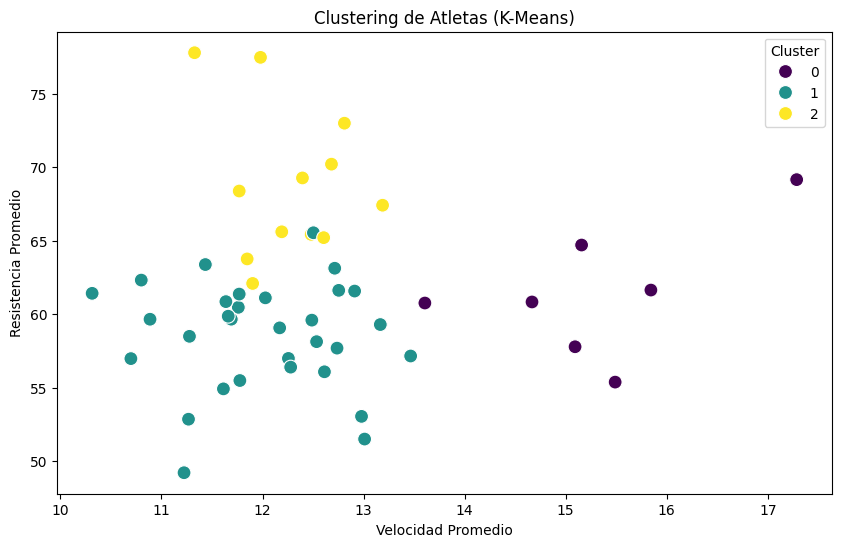

In [ ]:
# Visualización de Clusters: un gráfico rápido para ver los grupos en 2D:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='velocidad_prom', y='resistencia_prom',
    hue='cluster', data=df_agg, palette='viridis', s=100
)
plt.title(f'Clustering de Atletas ({metodo})')
plt.xlabel('Velocidad Promedio')
plt.ylabel('Resistencia Promedio')
plt.legend(title='Cluster')
plt.show()


In [ ]:
# Reducción de Dimensión (PCA, t-SNE, UMAP)
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Cargar datos con clusters
df_clusters = pd.read_csv("atletas_clusters.csv")

# Seleccionar features numéricas
features = ['velocidad_prom', 'resistencia_prom', 'fc_media_prom']
X = df_clusters[features]
X_scaled = StandardScaler().fit_transform(X)

# Colores para los gráficos
palette = sns.color_palette("viridis", n_colors=len(df_clusters['cluster'].unique()))


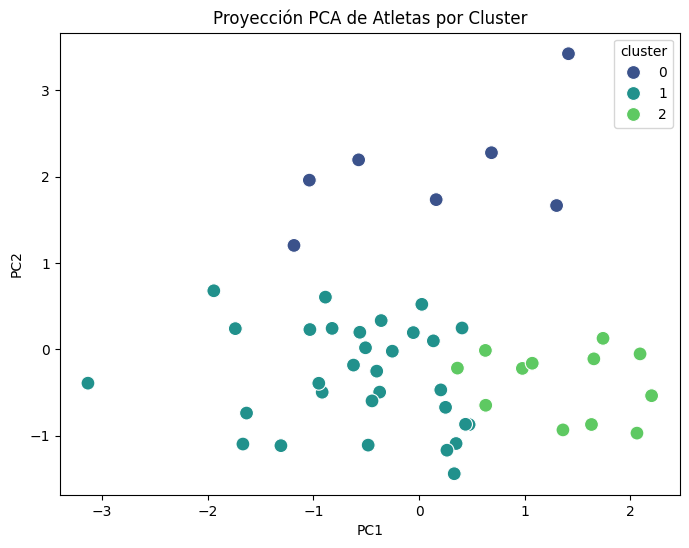

Varianza explicada total (PCA): 76.44%


In [ ]:
# vamos con PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df_clusters['PC1'], df_clusters['PC2'] = pca_result[:, 0], pca_result[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clusters, x='PC1', y='PC2', hue='cluster', palette=palette, s=100)
plt.title('Proyección PCA de Atletas por Cluster')
plt.show()

print(f"Varianza explicada total (PCA): {sum(pca.explained_variance_ratio_):.2%}")


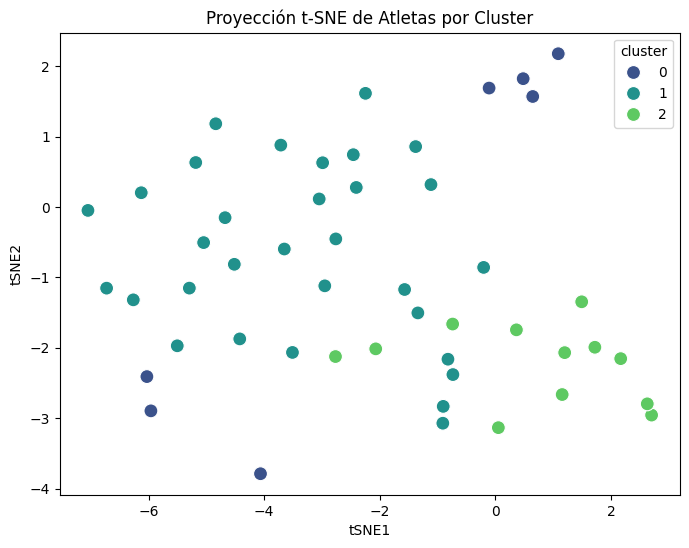

In [ ]:
# vamos con t-SNE
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)
df_clusters['tSNE1'], df_clusters['tSNE2'] = tsne_result[:, 0], tsne_result[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clusters, x='tSNE1', y='tSNE2', hue='cluster', palette=palette, s=100)
plt.title('Proyección t-SNE de Atletas por Cluster')
plt.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


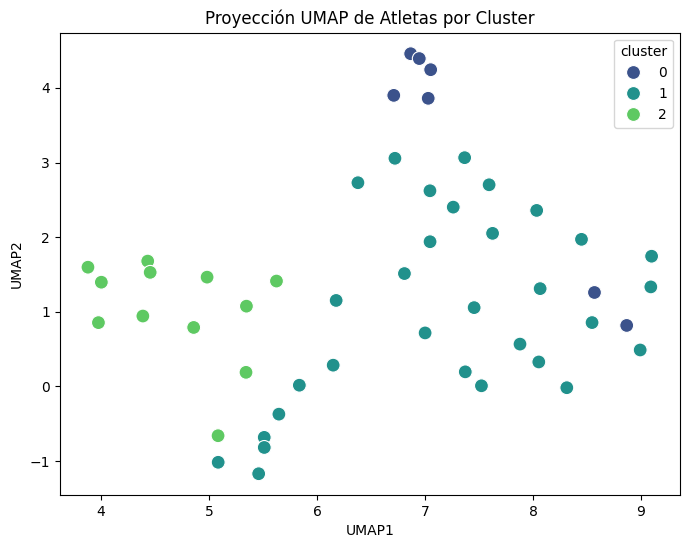

In [ ]:
# UMAP
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.2, random_state=42)
umap_result = umap_model.fit_transform(X_scaled)
df_clusters['UMAP1'], df_clusters['UMAP2'] = umap_result[:, 0], umap_result[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clusters, x='UMAP1', y='UMAP2', hue='cluster', palette=palette, s=100)
plt.title('Proyección UMAP de Atletas por Cluster')
plt.show()


In [ ]:
# Guardar archivo reducido
df_clusters[['atleta_id', 'cluster', 'PC1', 'PC2', 'tSNE1', 'tSNE2', 'UMAP1', 'UMAP2']].to_csv("reducido.csv", index=False)
print("Archivo 'reducido.csv' generado correctamente.")


Archivo 'reducido.csv' generado correctamente.


# interpretacion
PCA busca direcciones que expliquen la mayor parte de la varianza.

t-SNE y UMAP proyectan en 2D conservando la estructura local (los “vecinos” se mantienen cercanos).

Visualmente, si los clusters aparecen bien separados, tus grupos de atletas son coherentes y distinguibles.

Este paso es también la base para los gráficos interactivos y mapas

In [ ]:
# Cálculo de KPIs
import pandas as pd

# Cargar los datos agregados
df_agg = pd.read_csv("atletas_agg.csv")

# Calcular la media global de velocidad
velocidad_media_global = df_agg['velocidad_prom'].mean()

# Determinar qué atletas mejoraron >110% de la media
df_agg['mejoro'] = df_agg['velocidad_prom'] > (1.10 * velocidad_media_global)

# Calcular el porcentaje de mejora
porcentaje_mejoraron = (df_agg['mejoro'].sum() / len(df_agg)) * 100

# Otros KPIs opcionales
kpis = {
    "velocidad_media_global": round(velocidad_media_global, 2),
    "porcentaje_mejoraron": round(porcentaje_mejoraron, 2),
    "resistencia_promedio": round(df_agg['resistencia_prom'].mean(), 2),
    "fc_media_promedio": round(df_agg['fc_media_prom'].mean(), 2),
    "total_atletas": len(df_agg)
}

# Convertir a DataFrame y guardar
df_kpis = pd.DataFrame([kpis])
df_kpis.to_csv("kpis.csv", index=False)

print("Archivo 'kpis.csv' generado correctamente.")
display(df_kpis)


Archivo 'kpis.csv' generado correctamente.


,velocidad_media_global,porcentaje_mejoraron,resistencia_promedio,fc_media_promedio,total_atletas
0,12.53,12.0,61.41,150.16,50


Este es el corazón gráfico del proyecto.
transformamos todo el trabajo de análisis previo (EDA, clustering, reducción de dimensión, KPIs) en gráficos claros y profesionales, que luego podrán alimentar Power BI o un dashboard web.

In [ ]:
# Visualización Científica
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datasets necesarios
df_ts = pd.read_csv("datos_atletas.csv", parse_dates=["fecha"])
df_clusters = pd.read_csv("reducido.csv")
df_kpis = pd.read_csv("kpis.csv")

sns.set(style="whitegrid")


# Grafico de Serie temporal

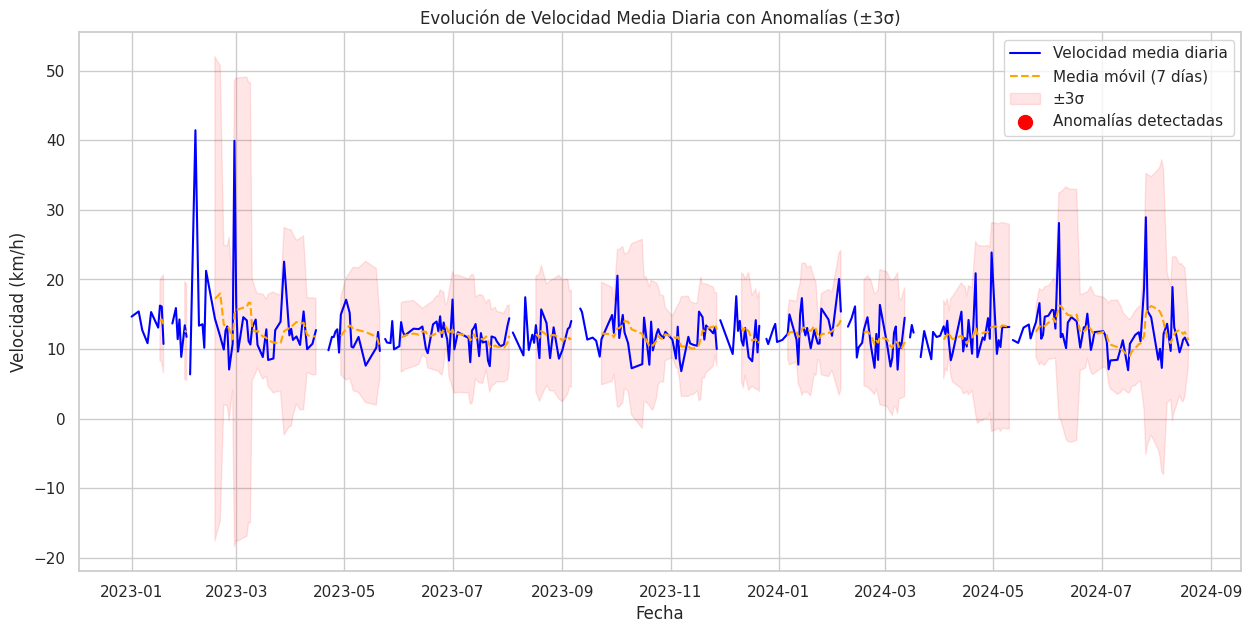

In [ ]:
# Calcular velocidad media diaria
df_ts_grouped = df_ts.groupby("fecha")["velocidad"].mean().reset_index()

# Calcular media móvil y límites
window = 7
df_ts_grouped["media_movil"] = df_ts_grouped["velocidad"].rolling(window).mean()
df_ts_grouped["std_movil"] = df_ts_grouped["velocidad"].rolling(window).std()
df_ts_grouped["lim_sup"] = df_ts_grouped["media_movil"] + 3 * df_ts_grouped["std_movil"]
df_ts_grouped["lim_inf"] = df_ts_grouped["media_movil"] - 3 * df_ts_grouped["std_movil"]

# Detectar anomalías
df_ts_grouped["anomalia"] = (df_ts_grouped["velocidad"] > df_ts_grouped["lim_sup"]) | \
                            (df_ts_grouped["velocidad"] < df_ts_grouped["lim_inf"])

# Plot
plt.figure(figsize=(15, 7))
plt.plot(df_ts_grouped["fecha"], df_ts_grouped["velocidad"], label="Velocidad media diaria", color="blue")
plt.plot(df_ts_grouped["fecha"], df_ts_grouped["media_movil"], label=f"Media móvil ({window} días)", color="orange", linestyle="--")
plt.fill_between(df_ts_grouped["fecha"], df_ts_grouped["lim_inf"], df_ts_grouped["lim_sup"], color="red", alpha=0.1, label="±3σ")
plt.scatter(df_ts_grouped[df_ts_grouped["anomalia"]]["fecha"],
            df_ts_grouped[df_ts_grouped["anomalia"]]["velocidad"],
            color="red", s=100, label="Anomalías detectadas")

plt.title("Evolución de Velocidad Media Diaria con Anomalías (±3σ)")
plt.xlabel("Fecha")
plt.ylabel("Velocidad (km/h)")
plt.legend()
plt.show()


# Gráfico Proyección PCA
analisis de componentes principales: representacion visual muestra como se distribuyen los datos en funcion de sus componentes pricipales

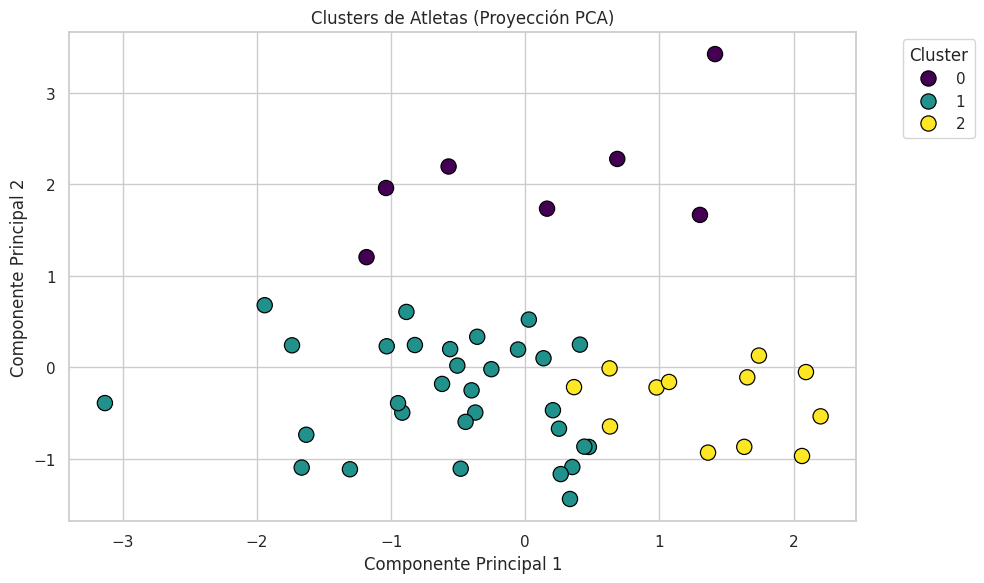

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_clusters,
    x="PC1", y="PC2",
    hue="cluster", palette="viridis", s=120, edgecolor="black"
)
plt.title("Clusters de Atletas (Proyección PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


# KPI en formato de barra simple
indicadr clave de desempeño, se utiliza para evaluar desempeño o rendimiento frente a una actividad especifica

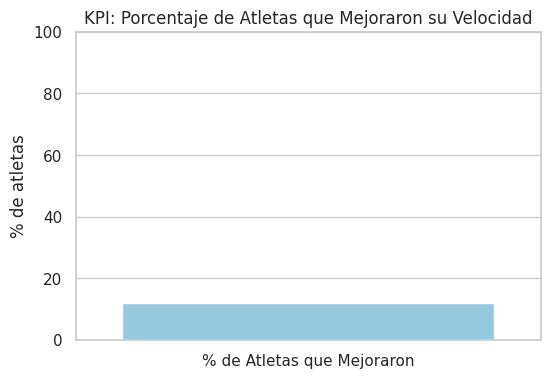

In [ ]:
plt.figure(figsize=(6, 4))
sns.barplot(x=["% de Atletas que Mejoraron"], y=[df_kpis.loc[0, "porcentaje_mejoraron"]], color="skyblue")
plt.title("KPI: Porcentaje de Atletas que Mejoraron su Velocidad")
plt.ylim(0, 100)
plt.ylabel("% de atletas")
plt.show()


# resumen
Una visión temporal (rendimiento y anomalías).

Una vista estructural (clusters en el espacio PCA).

Una síntesis (KPIs visuales).

# Mapas Estáticos y Dinámicos

In [ ]:
# Mapas Estáticos y Dinámicos
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import folium
from folium.plugins import MarkerCluster

# Cargar datos
df_geo = pd.read_csv("datos_atletas.csv")

# Crear geometrías (lat, lon)
geometry = [Point(xy) for xy in zip(df_geo["longitud"], df_geo["latitud"])]
gdf = gpd.GeoDataFrame(df_geo, geometry=geometry, crs="EPSG:4326")


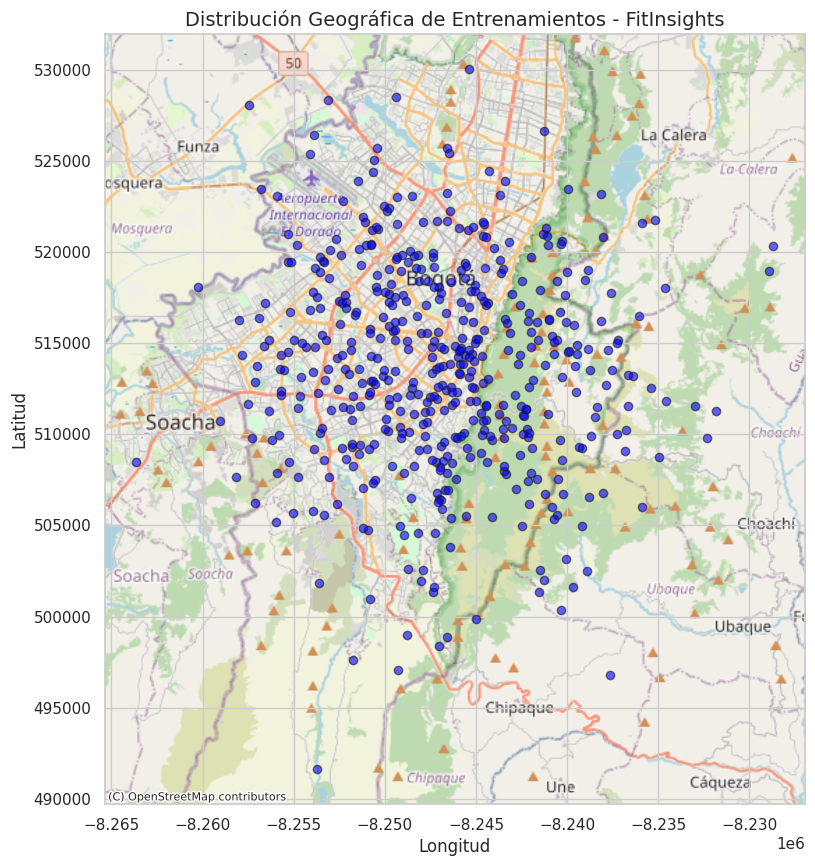

In [ ]:
# Convertir a proyección métrica
gdf_m = gdf.to_crs(epsg=3857)

# Crear figuracion de aproximacion
fig, ax = plt.subplots(figsize=(10, 10))
gdf_m.plot(ax=ax, alpha=0.6, edgecolor="k", color="blue")

# Añadir mapa base (OpenStreetMap)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Distribución Geográfica de Entrenamientos - FitInsights", fontsize=14)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


In [ ]:
# Centro del mapa (Bogotá aprox.)
m_center = [4.60971, -74.08175]
m = folium.Map(location=m_center, zoom_start=6, tiles="CartoDB positron")

# Añadir clúster de puntos
marker_cluster = MarkerCluster().add_to(m)

for _, row in df_geo.iterrows():
    popup_text = f"Atleta: {row['atleta_id']}<br>Velocidad: {row['velocidad']:.2f} km/h<br>Resistencia: {row['resistencia']:.1f} min"
    folium.Marker(
        location=[row["latitud"], row["longitud"]],
        popup=popup_text,
        icon=folium.Icon(color="blue", icon="running", prefix="fa")
    ).add_to(marker_cluster)

m


In [ ]:
from google.colab import files
files.download("datos_atletas.csv")
files.download("atletas_agg.csv")
files.download("reducido.csv")
files.download("kpis.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# resumen

Una vista espacial clara de dónde entrenan tus atletas.

Un mapa interactivo de exploración visual

Integración con las métricas previas (clusters, anomalías, KPIs).

# flujo de trabajo
 Paso 1: Generación de datos sintéticos  
 Paso 2: Carga y limpieza de datos  
 Paso 3: Análisis exploratorio y detección de anomalías  
 Paso 4: Persistencia en MongoDB Atlas  
 Paso 5: Streaming simulado con Kafka  
 Paso 6: Transformación con Spark SQL  
 Paso 7: Clustering y validación (K-Means / DBSCAN)  
 Paso 8: Reducción de dimensión (PCA, t-SNE, UMAP)  
 Paso 9: Cálculo de KPIs  
 Paso 10: Visualización científica  
 Paso 11: Mapas estáticos y dinámicos  
 Paso 12: Exportación para Power BI  
 Conclusiones y futuras extensiones


En este proyecto se diseñó y ejecutó un pipeline completo de análisis de rendimiento deportivo.
El conjunto de datos, generado sintéticamente, incluye variables de velocidad, resistencia, frecuencia cardíaca y geolocalización de entrenamientos.
Se aplicaron técnicas de limpieza, detección de anomalías (rolling ±3σ), clustering (K-Means, DBSCAN) y reducción de dimensión (PCA, t-SNE, UMAP).
Los resultados fueron almacenados en MongoDB Atlas y resumidos en artefactos CSV que alimentan un dashboard interactivo en Power BI.

## Conclusión final

FitInsights demuestra cómo una arquitectura de análisis moderna puede unir ciencia de datos, ingeniería y BI en un solo flujo reproducible.
El proyecto cierra la brecha entre el análisis exploratorio y la aplicación real en entornos deportivos o de salud, ofreciendo una base sólida para extenderse hacia un panel web en tiempo real con actualización continua de métricas

#Posibles mejoras

Orquestación y automatización:
Integrar el flujo completo con Airflow o Prefect para ejecuciones programadas.

Contenerización:
Empaquetar el notebook y las dependencias en Docker para despliegue reproducible.

Integración con APIs o sensores reales:
Reemplazar los datos sintéticos por flujos de dispositivos IoT (wearables, relojes GPS).

Panel web en tiempo real (fase 2):
Extender con backend Node + Mongo + Kafka y frontend React/Next.js

Infraestructura en la nube:
Migrar Spark y Mongo a servicios gestionados (Dataproc, Atlas, AWS EMR) para escalar horizontalmente.